In [2]:
library(dplyr)
library(tsibble)
library(fpp3) 
library(ggplot2)
library(corrplot)
library(ggcorrplot)
options(repr.plot.width=25)

calendar <- read.csv('Datasets/calendar_afcs2024.csv')
prices <- read.csv('Datasets/sell_prices_afcs2024.csv')
sales_train <- read.csv('Datasets/sales_train_validation_afcs2024.csv')
sales_val <- read.csv('Datasets/sales_test_validation_afcs2024.csv')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tsibble' was built under R version 4.4.2"
Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: 'tsibble'


The following objects are masked from 'package:base':

    intersect, setdiff, union


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────── fpp3 1.0.1 ──

✔ tibble      3.2.1.9033     ✔ tsibbledata 0.4.1     
✔ tidyr       1.3.1          ✔ feasts      0.4.1     
✔ lubridate   1.9.3          ✔ fable       0.4.1     
✔ ggplot2     3.5.1          

Warning message:
"package 'tsibbledata' was built under R version 4.4.2"
Warning message:
"package 'feasts' was built under R version 4.4.2"
Warning message:
"package 'fabletools' was built 

In [3]:
# Transpose sale CSV to match forcasting-usable format
# After transpose, ensure datatypes are int, surpress row names being selected in df

sales_transposed <- t(sales_train)
sales_df <- as.data.frame(sales_transposed[-1,]) %>% mutate_all(as.integer)
colnames(sales_df) <- sales_transposed[1,]
row.names(sales_df) <- NULL

#sales_df <- tibble::rownames_to_column(sales_df, "Day")
#sales_ts <- as_tsibble(sales_df, index = Day)
#sales_ts <- as_tsibble(sales_df)

# Count totals over the rows, just as a possible informative data about overall food items sales
# Add day counter to both df's to make merging possible (otherwise no key)

sales_df$total <- rowSums(sales_df)
sales_df$day <- 1:nrow(sales_df)
calendar$day <- 1:nrow(calendar)

In [4]:
# Merge dataframes and convert to tsibble 

calendar_sales <- merge(calendar,sales_df)
calendar_sales <- calendar_sales %>% as_tsibble(index = day)
calendar_sales$is_event <- ifelse(calendar_sales$event_name_1 != "NA", 1, 0)


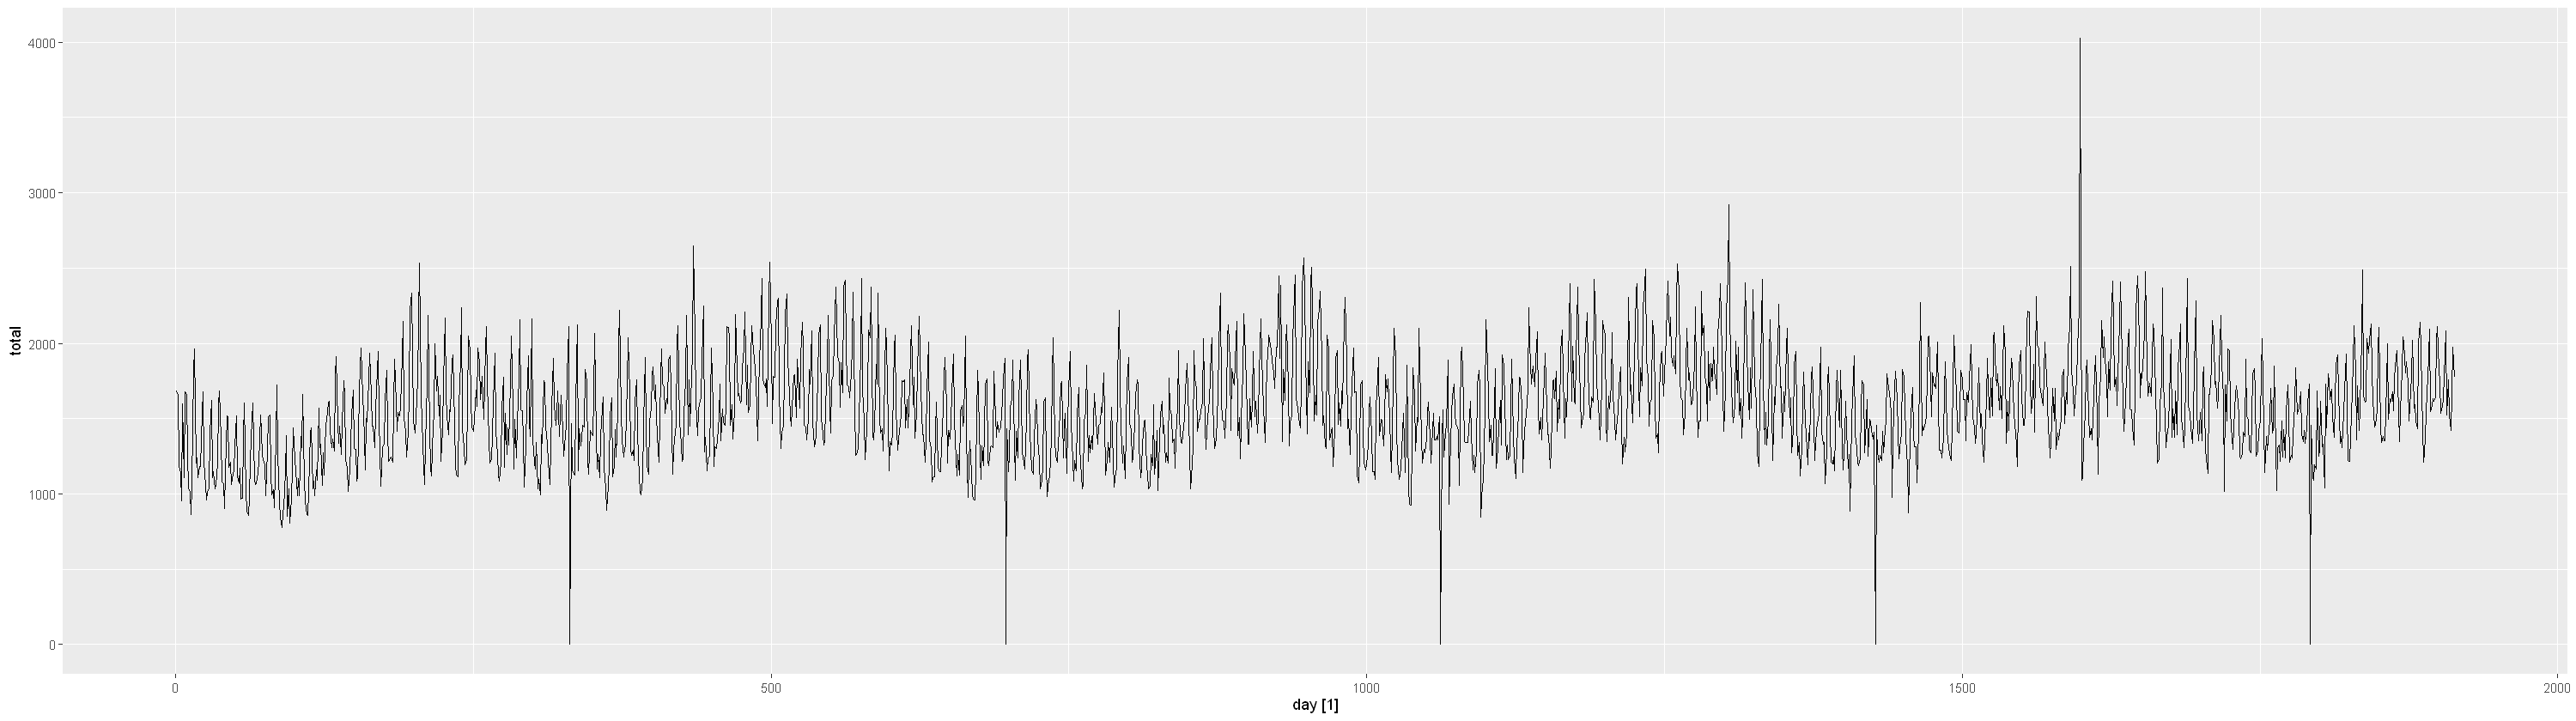

In [6]:
# Overall Food sales, informative. See cyclic behavior 

calendar_sales %>% autoplot(total)

In [7]:
is_regular(calendar_sales)

[1] TRUE

In [8]:
# Probably closed on christmas, sales is are aprox 0.
# Positive outlier on jun 15 2015, 4027 sales for some reason

calendar_sales[calendar_sales$total <=5, ]
calendar_sales[calendar_sales$total >=3500, ]

day,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,⋯,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation,total,is_event
<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
331,12/25/2011,11148,Sunday,2,12,2011,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,2,1
697,12/25/2012,11248,Tuesday,4,12,2012,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,2,1
1062,12/25/2013,11348,Wednesday,5,12,2013,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,1,1
1427,12/25/2014,11447,Thursday,6,12,2014,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,4,1
1792,12/25/2015,11547,Friday,7,12,2015,Christmas,National,NA,⋯,0,0,0,0,0,0,0,0,2,1


day,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,⋯,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation,total,is_event
<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1599,6/15/2015,11520,Monday,3,6,2015,NA,NA,NA,⋯,1,1,4,0,0,0,2,0,4027,NA


In [10]:
calendar2 <- calendar 
calendar2$name <- 1:nrow(calendar)
sales <- sales_train %>% pivot_longer (2:ncol(sales_train)) 
sales$name <- gsub("d_", "", sales$name)
sales$id <- gsub("_TX_3_validation", "" ,sales$id)
sales$name <- as.integer(sales$name)

sales
calendar2

id,name,value
<chr>,<int>,<int>
FOODS_3_001,1,0
FOODS_3_001,2,2
FOODS_3_001,3,1
FOODS_3_001,4,3
FOODS_3_001,5,0
FOODS_3_001,6,0
FOODS_3_001,7,1
FOODS_3_001,8,0
FOODS_3_001,9,2


date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,day,name
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
1/29/2011,11101,Saturday,1,1,2011,NA,NA,NA,NA,0,1,1
1/30/2011,11101,Sunday,2,1,2011,NA,NA,NA,NA,0,2,2
1/31/2011,11101,Monday,3,1,2011,NA,NA,NA,NA,0,3,3
2/1/2011,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1,4,4
2/2/2011,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0,5,5
2/3/2011,11101,Thursday,6,2,2011,NA,NA,NA,NA,1,6,6
2/4/2011,11101,Friday,7,2,2011,NA,NA,NA,NA,0,7,7
2/5/2011,11102,Saturday,1,2,2011,NA,NA,NA,NA,1,8,8
2/6/2011,11102,Sunday,2,2,2011,SuperBowl,Sporting,NA,NA,1,9,9


In [12]:
calendar2_sales <- left_join(sales,calendar2, by='name') 
calendar2_sales$date <- as.Date(calendar2_sales$date, format = "%m/%d/%Y")
calendar2_sales <- calendar2_sales %>% as_tsibble(index = date , key = id)
calendar2_sales <- left_join(calendar2_sales, prices, by = c("wm_yr_wk" = "wm_yr_wk", "id"="item_id"))
#calendar2_sales$is_event <- ifelse(calendar2_sales$event_name_1 != "NA", 1, 0)

In [15]:
weekdays <- list('Monday', 'Tuesday', 'Wednesday', 'Thursday')
weekend <- list('Friday','Saturday')

In [88]:
calendar2_sales$is_weekend <- ifelse(calendar2_sales$weekday %in% weekend, 1, 0)
calendar2_sales$event_name_1 <- replace(calendar2_sales$event_name_1, is.na(calendar2_sales$event_name_1), 0)
calendar2_sales$is_event <- ifelse(calendar2_sales$event_name_1 != 0, 1, 0)

final_data <- calendar2_sales[c("id","name","value",'date','wday','wm_yr_wk','weekday','month', 'year','event_name_1','event_type_1','snap_TX','sell_price','is_event','is_weekend')]
final_data_numeric <- final_data[c('id','name','value','month','sell_price','is_event','is_weekend')]

final_data_numeric_2 <- final_data[c('id','name','value','month','sell_price','is_event','is_weekend')]
final_data_numeric_2$id <- gsub("FOODS_3_", "" ,final_data_numeric_2$id)

final_data_numeric_3 <- final_data[c('value','wday','month','sell_price','is_event','is_weekend', 'snap_TX')]
final_data_numeric_4 <- final_data[c('value','wday','month','sell_price','is_event','is_weekend', 'snap_TX')]
names(final_data_numeric_4)[names(final_data_numeric_4) == 'value'] <- 'Amount sold'

final_data_numeric$value <- as.double(final_data_numeric$value)
final_data_numeric$name <- as.double(final_data_numeric$name)
final_data_numeric$month <- as.double(final_data_numeric$month)

In [83]:
final_data_numeric_4

name,Amount sold,month,sell_price,is_event,is_weekend,snap_TX
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,0,1,2.28,0,1,0
2,2,1,2.28,0,1,0
3,1,1,2.28,0,0,0
4,3,2,2.28,0,0,1
5,0,2,2.28,0,0,0
6,0,2,2.28,0,0,1
7,1,2,2.28,0,1,0
8,0,2,2.28,0,1,1
9,2,2,2.28,1,1,1


In [31]:
cormat

,name,value,month,sell_price,is_event,is_weekend
name,1.00,0.01,0.03,0.02,0.00,0.00
value,0.01,1.00,0.00,-0.13,0.00,0.03
month,0.03,0.00,1.00,0.00,-0.07,0.00
sell_price,0.02,-0.13,0.00,1.00,0.00,0.00
is_event,0.00,0.00,-0.07,0.00,1.00,-0.04
is_weekend,0.00,0.03,0.00,0.00,-0.04,1.00


In [ ]:
# Calculate the correlation matrix
cor_matrix <- cor(mtcars)
# Create a basic correlation heatmap using corrplot
corrplot(cor_matrix, method = "color")

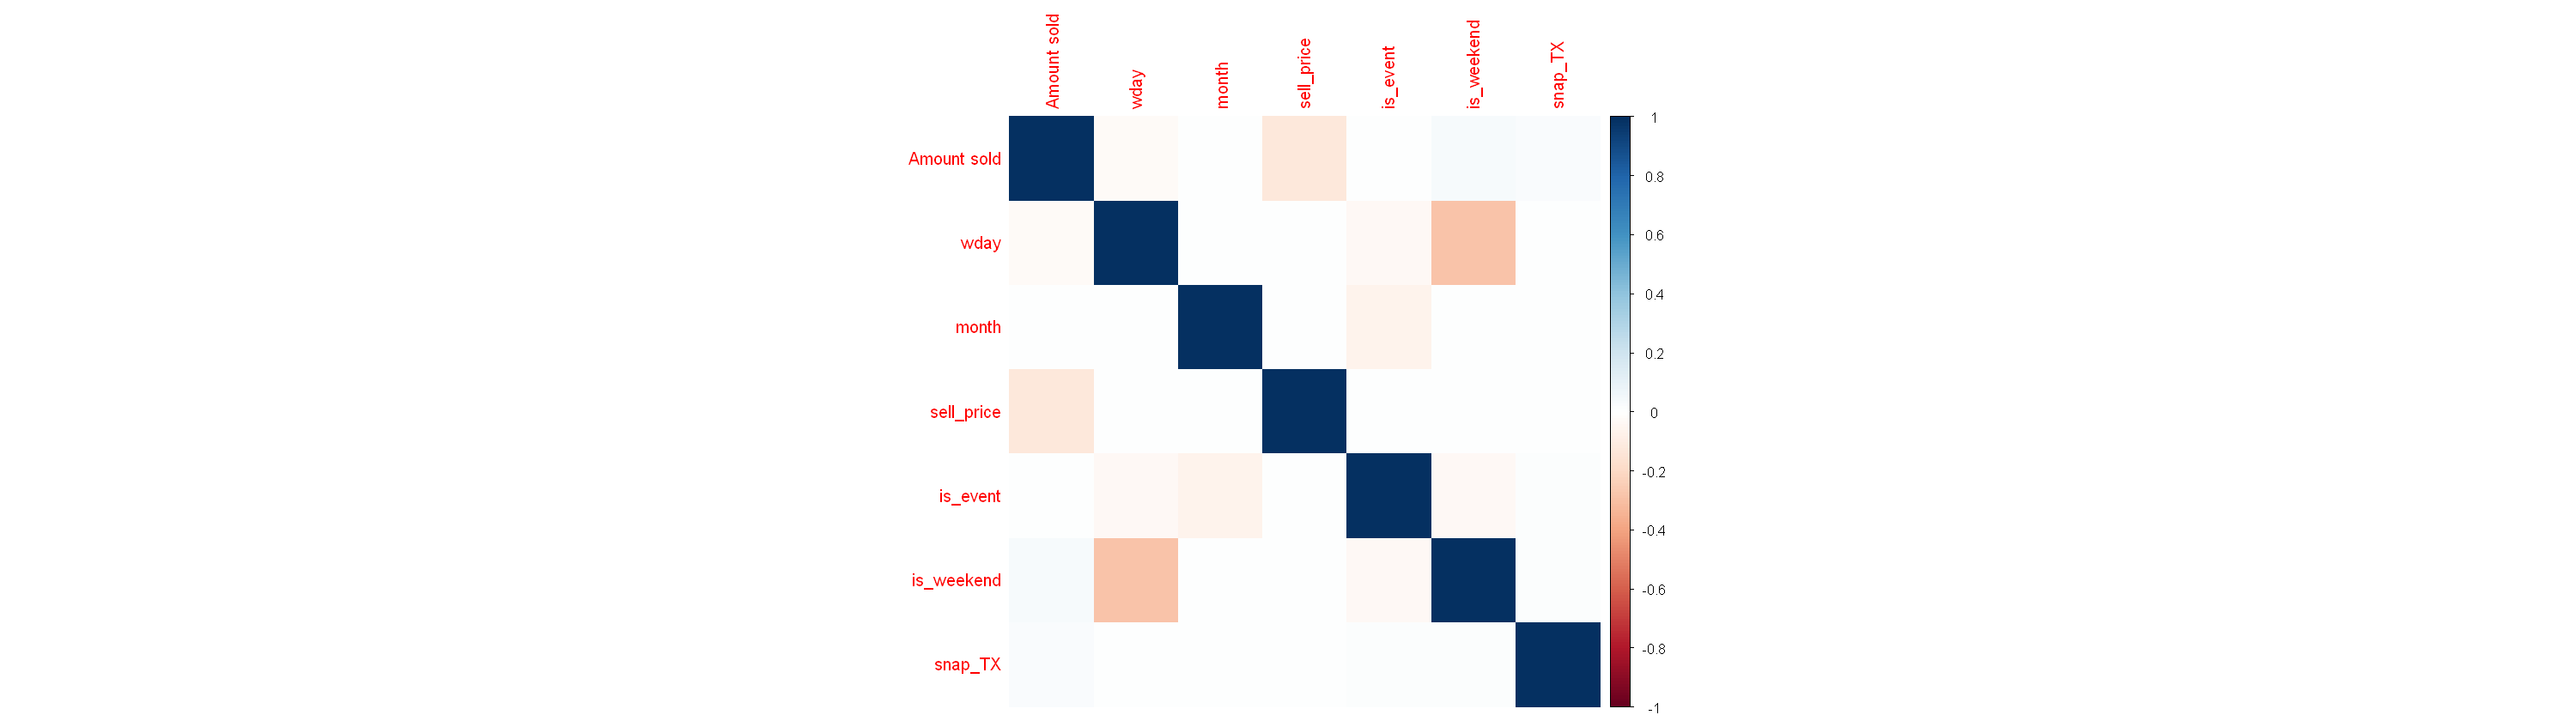

In [89]:
cormat <- round(cor(final_data_numeric_4, use = "pairwise.complete.obs"),2)
corrplot(cormat, method = "color")

In [37]:
to_forecast <- final_data_numeric %>% as_tsibble(key = "id", index="name")

In [38]:
x<- to_forecast %>% model(NAIVE(value)) %>% forecast(h=28)

In [26]:
fc <- x %>% filter(id == "FOODS_3_827" | id == "FOODS_3_001")
#l <- fc[c("id","name", ".mean")]
#l <- pivot_wider(fc)
#pivot_wider(l)

In [27]:
#ARIMA final_data_numeric
arima <- fc %>% model(ARIMA(value)) #%>% forecast(h=28)

Warning message:
"2 errors (1 unique) encountered for ARIMA(value)
[2] incorrect number of subscripts on matrix
"


In [39]:
x <-as_tsibble(final_data_numeric, index="name", key="id" )

In [40]:
arima <- x %>% model(ARIMA(value)) %>% forecast(h=28)

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning 

In [167]:
arima_rounded <- arima
arima_rounded$.mean <- ceiling(arima_rounded$.mean)

In [168]:
arima_rounded2 <- arima[c('id', 'name','.mean')]
arima_rounded2$.mean <- ceiling(arima_rounded$.mean)

In [155]:
sales_val_long <- sales_val %>% pivot_longer (2:ncol(sales_val))
sales_val_long$name <- gsub ("d_", "" ,sales_val_long$name)
sales_val_long$id <- gsub ("_TX_3_validation", "" ,sales_val_long$id)
sales_val_long$name <- as.integer(sales_val_long$name)
sales_val_long <-as_tsibble(sales_val_long, index="name", key="id" )

In [45]:
arima_results <- summary(accuracy(arima,sales_val_long) %>% select(ME:MAE))

In [46]:
croston_results <- summary(accuracy(croston,sales_val_long) %>% select(ME:MAE))

In [47]:
arima_rounded_results <- summary(accuracy(arima_rounded,sales_val_long) %>% select(ME:MAE))

In [48]:
arima_results

       ME                RMSE             MAE         
 Min.   :-5.56427   Min.   : 0.000   Min.   : 0.0000  
 1st Qu.:-0.09409   1st Qu.: 0.672   1st Qu.: 0.5326  
 Median : 0.07435   Median : 1.134   Median : 0.8709  
 Mean   : 0.26161   Mean   : 1.827   Mean   : 1.3997  
 3rd Qu.: 0.34871   3rd Qu.: 1.957   3rd Qu.: 1.4982  
 Max.   :18.10714   Max.   :25.588   Max.   :19.6274  

In [49]:
arima_rounded_results

       ME                RMSE             MAE         
 Min.   :-5.56427   Min.   : 0.000   Min.   : 0.0000  
 1st Qu.:-0.09409   1st Qu.: 0.672   1st Qu.: 0.5326  
 Median : 0.07435   Median : 1.134   Median : 0.8709  
 Mean   : 0.26161   Mean   : 1.827   Mean   : 1.3997  
 3rd Qu.: 0.34871   3rd Qu.: 1.957   3rd Qu.: 1.4982  
 Max.   :18.10714   Max.   :25.588   Max.   :19.6274  

In [176]:
ETS_flat <- to_forecast %>% 
model(ETS(value)) %>% forecast(h=28)
ETS_flat$.mean <- ceiling(ETS_flat$.mean)

In [178]:
ETS_flat_results <- summary(accuracy(ETS_flat,sales_val_long) %>% select(ME:MAE))

In [189]:
ETS_flat_results

       ME                 RMSE              MAE         
 Min.   :-18.63255   Min.   : 0.0000   Min.   : 0.0000  
 1st Qu.: -0.09992   1st Qu.: 0.6584   1st Qu.: 0.5395  
 Median :  0.06525   Median : 1.1288   Median : 0.8665  
 Mean   :  0.20009   Mean   : 1.8890   Mean   : 1.4639  
 3rd Qu.:  0.34544   3rd Qu.: 1.9765   3rd Qu.: 1.5012  
 Max.   : 18.10714   Max.   :25.5422   Max.   :20.0569  

In [151]:
FOODS_3_001 =arima_rounded2 %>% filter(id == "FOODS_3_109") 

Plot variable not specified, automatically selected `.vars = .mean`


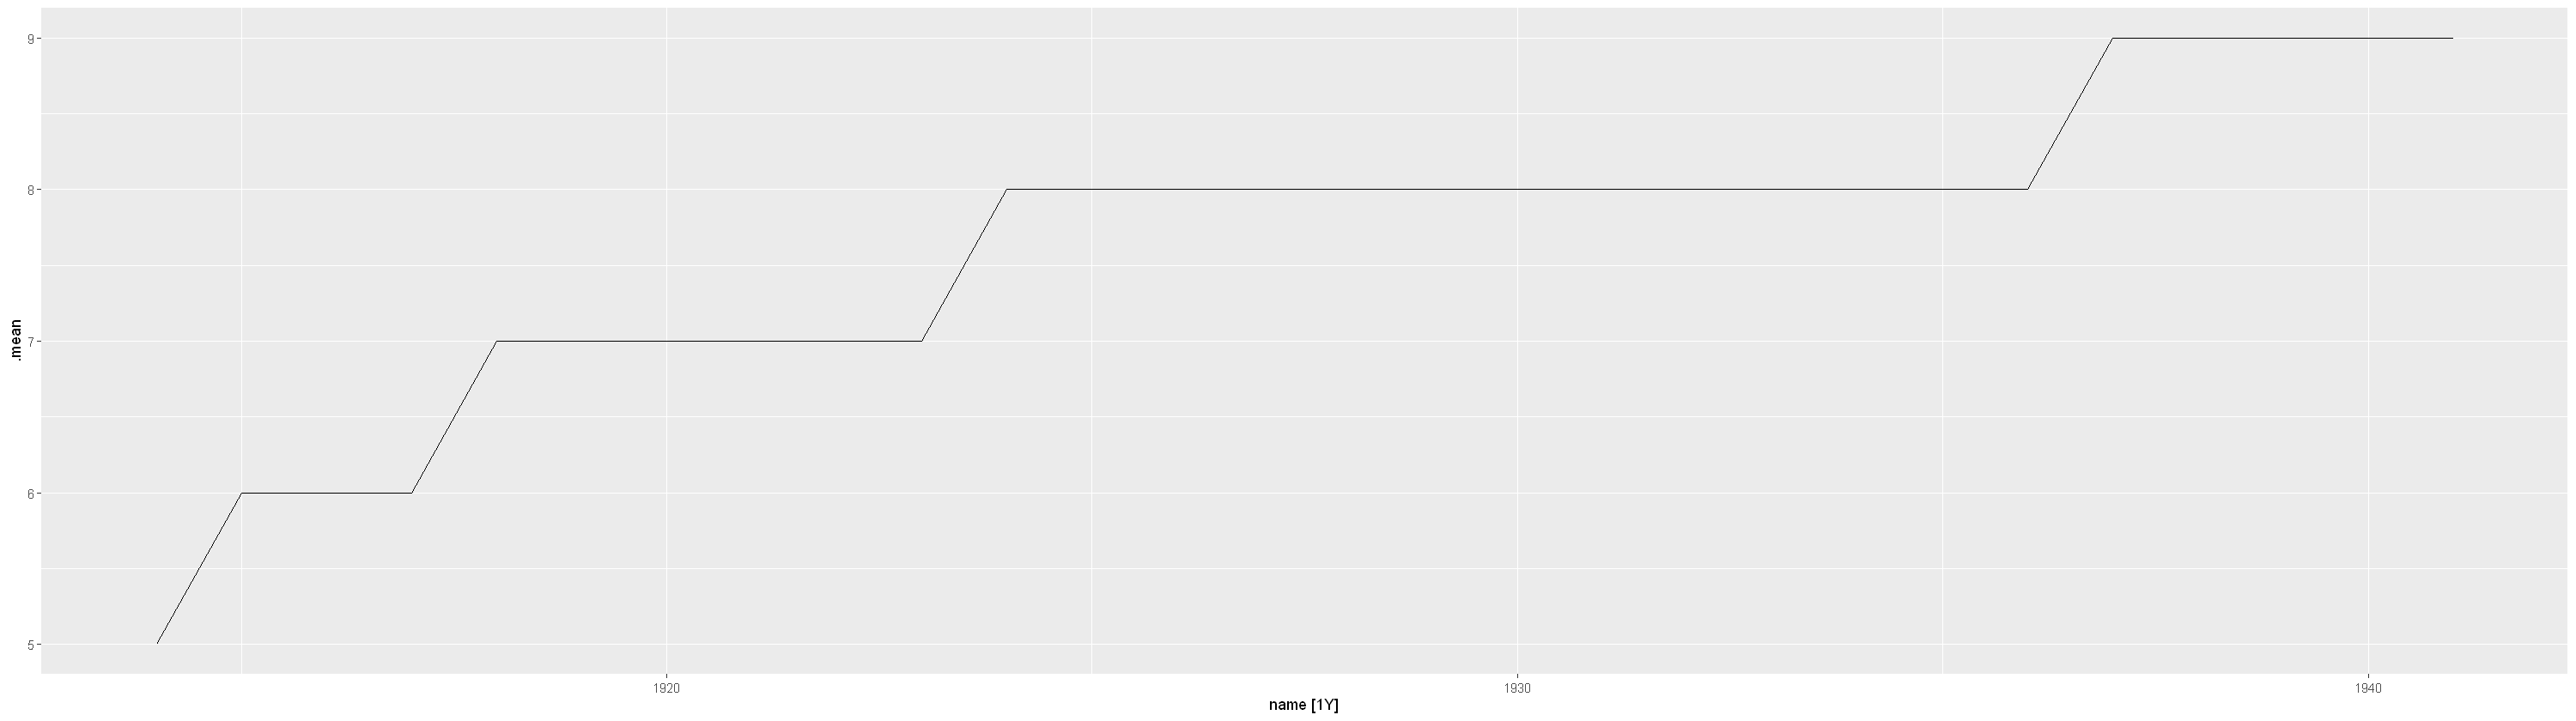

In [152]:
autoplot(as_tsibble(FOODS_3_001, index=name, key=id))

In [190]:
arima_rounded$id <- paste0(arima_rounded$id,"_TX_3_validation")
write.csv2(arima_rounded, "ARIMA_submission.csv")

In [186]:
arima_sub <- arima_rounded[c('id','name','.mean')]
arima_sub <- arima_sub %>% pivot_wider(names_from = name, values_from = .mean)

In [191]:
ETS_flat$id <- paste0(ETS_flat$id,"_TX_3_validation")

In [187]:
ETS_sub <- ETS_flat[c('id','name','.mean')]
ETS_sub <- ETS_sub %>% pivot_wider(names_from = name, values_from = .mean)

write.csv2(ETS_sub, "ETS_Flat_submission.csv")